In [2]:
from spectra import Spectra
import csv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wavelengths = np.arange(400, 701, 10)

In [4]:
mixed_samples = {}
with open(f'PrintColors/inks.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths)
        mixed_samples[row[4]] = spectra
        

In [5]:
from observer import Cone, Observer

def remove_trailing_nans(arr):
    mask = np.any(np.isnan(arr), axis=1)
    idx = np.where(mask)[0]
    if idx.size > 0:
        last_valid_idx = np.where(~mask)[0][-1]
        return arr[:last_valid_idx + 1]
    return arr

cone_data = np.genfromtxt('linss2_10e_1.csv', delimiter=',')


l_cone = Cone(cone_data[:311, [0, 1]])
m_cone = Cone(cone_data[:311, [0, 2]])
s_cone = Cone(remove_trailing_nans(cone_data[:311, [0, 3]]))

shift = 15
r = [(w,1e-4) for w in m_cone.wavelengths() if w < m_cone.wavelengths()[0]+shift] + \
        [(w+shift,v) for (w,v) in m_cone.reflectance if w+shift <= m_cone.wavelengths()[-1]]
q_cone = Cone(reflectance=np.array(r))


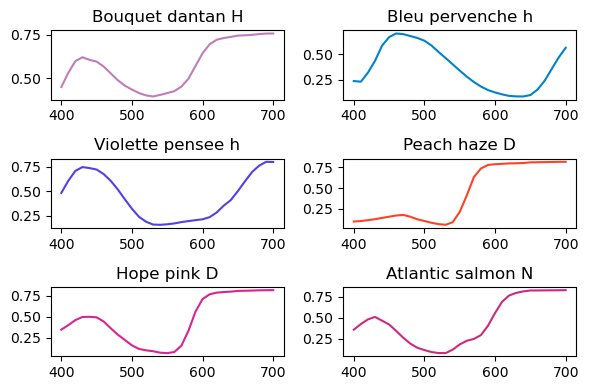

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(6, 4))
axes = axes.ravel()  # Flatten the axes array for easy iteration

count = 0
for i, (name, spectra) in enumerate(mixed_samples.items()):
#     l_cone.plot(ax=axi,color='black', alpha=0.5)
#     q_cone.plot(ax=axi,color='black', alpha=0.5)
#     m_cone.plot(ax=axi,color='black', alpha=0.5)
#     s_cone.plot(ax=axi,color='black', alpha=0.5)
    if i in [0, 2, 3, 5, 6, 7]:
        axi = axes[count]
        spectra.plot(ax=axi)
        axi.set_title(name)
        count += 1

    
plt.tight_layout()
fig.savefig("fountainpens2.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
mixed_samples

{'Bouquet dantan H': <spectra.Spectra at 0x10bfeffd0>,
 'Rose cyclamen H': <spectra.Spectra at 0x10bde0650>,
 'Bleu pervenche h': <spectra.Spectra at 0x10bf7d450>,
 'Violette pensee h': <spectra.Spectra at 0x10c161410>,
 'Orange D': <spectra.Spectra at 0x10c109050>,
 'Peach haze D': <spectra.Spectra at 0x10c161450>,
 'Hope pink D': <spectra.Spectra at 0x10c160810>,
 'Atlantic salmon N': <spectra.Spectra at 0x10c1614d0>,
 'Operation overlord orange N': <spectra.Spectra at 0x10c1608d0>,
 'Dragon catfish N': <spectra.Spectra at 0x10c161550>}

## Best samples

In [12]:
mixed_samples

{'Bouquet dantan H': <spectra.Spectra at 0x11c64f3d0>,
 'Rose cyclamen H': <spectra.Spectra at 0x11c64f410>,
 'Bleu pervenche h': <spectra.Spectra at 0x11c438f50>,
 'Violette pensee h': <spectra.Spectra at 0x11c64f450>,
 'Orange D': <spectra.Spectra at 0x11c64f590>,
 'Peach haze D': <spectra.Spectra at 0x11c65c190>,
 'Hope pink D': <spectra.Spectra at 0x11c64f6d0>,
 'Atlantic salmon N': <spectra.Spectra at 0x11c65c210>,
 'Operation overlord orange N': <spectra.Spectra at 0x11c64f810>,
 'Dragon catfish N': <spectra.Spectra at 0x11c65c290>}

In [15]:
from observer import Cone, Observer
from models import gaussian, Neugebauer

In [16]:
cmy_primaries_dict = {}
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

primary_fns = [
    "000",
    "001",
    "010",
    "100",
    "011",
    "110",
    "101",
    "111",
]

for fn in primary_fns:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths10)
                cmy_primaries_dict[fn] = spectra
                
paper = cmy_primaries_dict["000"]
cmy_neugebauer = Neugebauer(cmy_primaries_dict)

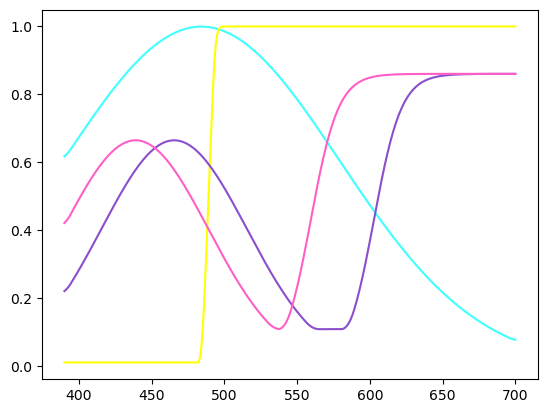

In [17]:
new_pigments = []

fig, ax3 = plt.subplots()
for pigment in np.load("new_pigments.npy"):
    spectra = Spectra(data=np.clip(pigment, 0.01, 1), wavelengths=wavelengths1)
    spectra.plot(ax=ax3)
    new_pigments.append(spectra.interpolate_values(wavelengths10))

In [21]:
cyan = cmy_primaries_dict["100"]
yellow = cmy_primaries_dict["001"]
magenta = cmy_primaries_dict["010"]

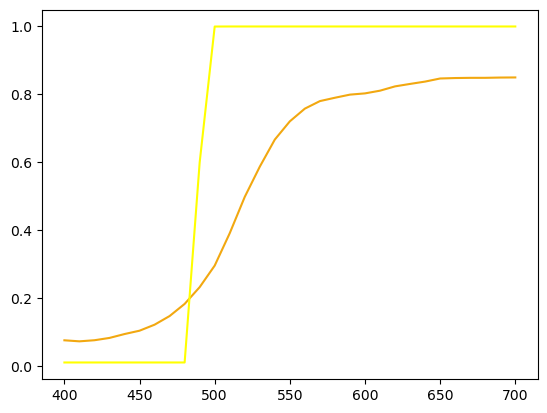

In [25]:
yellow.plot()
new_pigments[1].plot()

In [32]:
def FakeColor(wavelengths,gaussianSig,gaussianHeight,gaussianMu,passSlope,passOffset,passHeight,base=1e-4) -> Spectra:
    def gaussian(x):
        return np.maximum(gaussianHeight * np.exp(-(x - gaussianMu) ** 2 / (2 * gaussianSig ** 2)),base)
    def passFilter(x):
        return passHeight/(1+np.exp(-passSlope*(x-passOffset)))
    points = np.maximum(gaussian(wavelengths),passFilter(wavelengths))
    windowSize = 9
    pad = (windowSize - 1) // 2
    points = np.concatenate([(np.ones(pad) * points[0]) , points , (np.ones(pad) * points[-1])])
    window = np.ones(windowSize)/windowSize
    curve = np.convolve(points,window,mode='valid')
    return Spectra(wavelengths=wavelengths,data=curve)

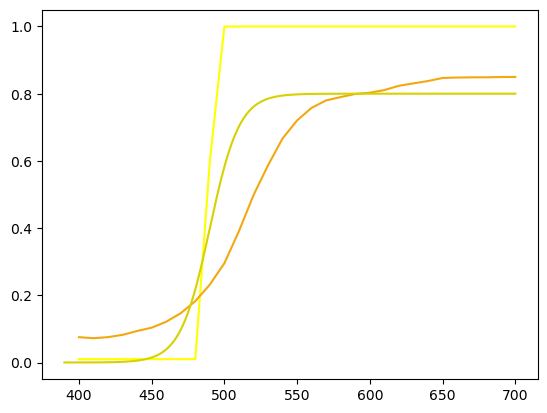

In [52]:
test = FakeColor(wavelengths1,
                 60,.7, 100, 
                 0.1, 490, .8)
new_pigments[1].plot()
yellow.plot()
test.plot()

In [53]:
test.to_rgb() * 256

array([216.92854221, 209.39704326,   0.        ])